In [7]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import unittest

In [8]:
# Step 1: Loading the Dataset
def load_data(file_path):
    """Load dataset from a CSV file."""
    data = pd.read_csv(file_path, encoding='ISO-8859-1')
    return data



In [9]:
def preprocess_data(data):
    """Clean and preprocess the data."""
    data.fillna(method='ffill', inplace=True)  # Forward fill for simplicity
    data = pd.get_dummies(data, columns=['gender', 'country', 'language'])  # One-hot encoding
    
    return data



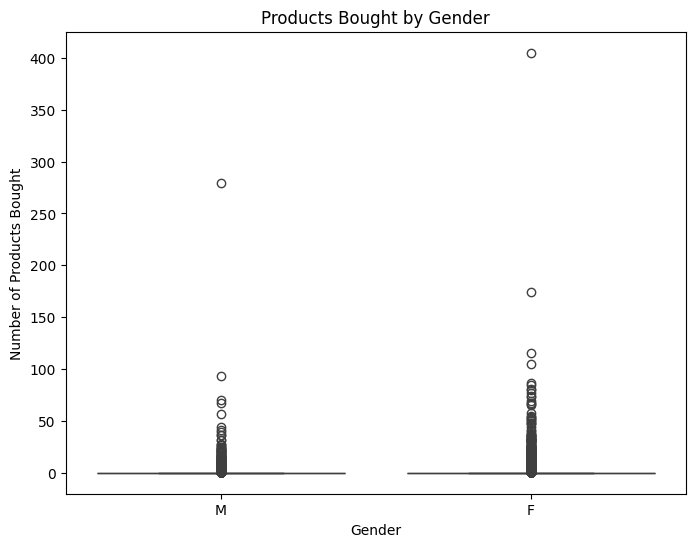

  gender  productsBought
0      F        0.167418
1      M        0.186995


C:\Users\acer\AppData\Local\Temp\ipykernel_19276\3840259505.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # Forward fill for simplicity



--- Language Purchase Impact (Based on Full Dataset) ---
  primary_language  productsBought
0               de        0.237531
1               en        0.172950
2               es        0.132107
3               fr        0.166313
4               it        0.154520


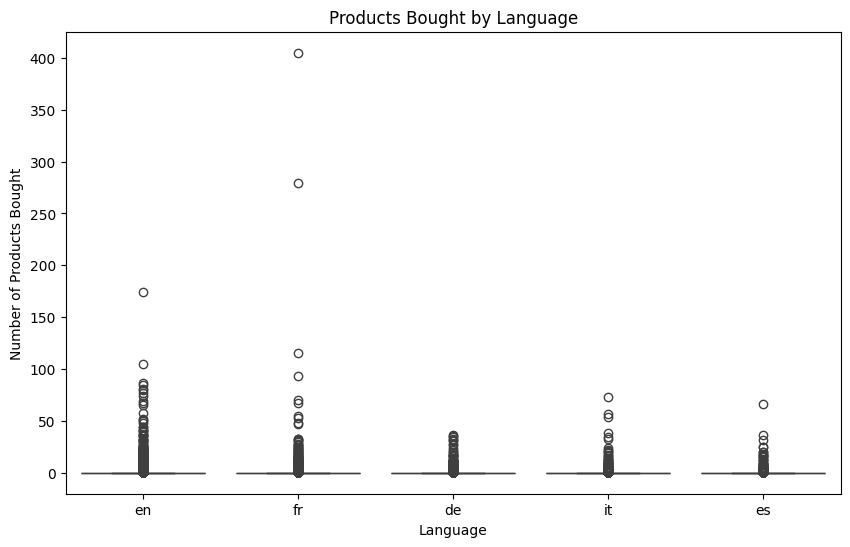

In [10]:
data = pd.read_csv('6M-0K-99K.users.dataset.public.csv', encoding='ISO-8859-1')
# print(data.info())  # General information about the dataset
# print(data.describe()) 
# Boxplot of Products Bought by Gender
plt.figure(figsize=(8, 6))
sns.boxplot(x='gender', y='productsBought', data=data)
plt.title('Products Bought by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Products Bought')
plt.show()

# Average Products Bought by Gender
avg_products_by_gender = data.groupby('gender')['productsBought'].mean().reset_index()
print(avg_products_by_gender)

processed_full_data = preprocess_data(data.copy())

# Analyze the impact of language on products bought
language_cols = [col for col in processed_full_data.columns if col.startswith('language_')]

# Create a new column indicating the primary language
processed_full_data['primary_language'] = processed_full_data[language_cols].idxmax(axis=1).str.replace('language_', '')

language_purchase_impact = processed_full_data.groupby('primary_language')['productsBought'].mean().reset_index()
print("\n--- Language Purchase Impact (Based on Full Dataset) ---")
print(language_purchase_impact)

# Visualize Language Impact
plt.figure(figsize=(10, 6))
sns.boxplot(x='primary_language', y='productsBought', data=processed_full_data)
plt.title('Products Bought by Language')
plt.xlabel('Language')
plt.ylabel('Number of Products Bought')
plt.show()

# Determine purchase probability ranges based on language interaction
language_prob_ranges = {
    'de': (0.3, 0.6),
    'en': (0.2, 0.5),
    'es': (0.1, 0.4),
    'fr': (0.2, 0.5),
    'it': (0.15, 0.45),
}

In [11]:
class UserAgent(Agent):
    """An agent representing a user with demographics."""
    
    def __init__(self, unique_id, model, demographics,purchase_prob_female_range=(0.3, 0.6), purchase_prob_male_range=(0.2, 0.5), language_prob_ranges=None):
        super().__init__(model)
        
        # Gender
        self.gender_male = demographics.get('gender_M', 0)
        self.gender_female = demographics.get('gender_F', 0)
        
        # Countries 
        self.country_afrique_du_sud = demographics.get('country_Afrique du Sud', 0)
        self.country_albanie = demographics.get('country_Albanie', 0)
        
        # Languages
        self.language_de = demographics.get('language_de', 0)
        self.language_en = demographics.get('language_en', 0)
        self.language_es = demographics.get('language_es', 0)
        self.language_fr = demographics.get('language_fr', 0)
        self.language_it = demographics.get('language_it', 0)
        
        # Other attributes
        self.login_frequency = random.randint(1, 7)  # Random login frequency (1-7 days)
        self.purchase_prob_female_range = purchase_prob_female_range
        self.purchase_prob_male_range = purchase_prob_male_range
        self.language_prob_ranges = language_prob_ranges if language_prob_ranges else {}
        self.purchase_probability = self.set_purchase_probability()
        
    def set_purchase_probability(self):
        base_probability = 0.0

        if self.gender_female:
            base_probability = random.uniform(*self.purchase_prob_female_range)
        elif self.gender_male:
            base_probability = random.uniform(*self.purchase_prob_male_range)

        # Adjust probability based on language
        for lang, prob_range in self.language_prob_ranges.items():
            if getattr(self, lang, 0) == 1:
                #  Here, we are averaging the base probability with the language-specific range.
                #  You can implement more complex logic based on how you want language to affect it.
                language_prob = random.uniform(*prob_range)
                base_probability = (base_probability + language_prob) / 2
                break  # Assuming only one language is True

        return base_probability
        
    def step(self):
        """Simulate user behavior."""
        if random.random() < self.purchase_probability:
            self.model.total_purchases += 1
            # print(f"Agent {self.unique_id}: Purchase Probability = {self.purchase_probability}, Random Value = {random.random()}")

In [17]:
class UserBehaviorModel(Model):
    """A model with some number of users."""
    
    def __init__(self, demographics, language_prob_ranges):
        super().__init__()  # Initializing the parent class without arguments
        self.num_agents = len(demographics)
        self.grid = MultiGrid(10, 10, True)
        self.schedule = RandomActivation(self)
        self.total_purchases = 0
        self.datacollector = DataCollector(
            agent_reporters={
        "Purchases": "purchase_probability",
        "Gender_Male": "gender_male",
        "Gender_Female": "gender_female",
        "Language_de": "language_de",
        "Language_en": "language_en",
        "Language_es": "language_es",
        "Language_fr": "language_fr",
        "Language_it": "language_it",
        "Country_afrique_du_sud": "country_afrique_du_sud",
        "Country_albanie": "country_albanie",
    }
        )
        self.language_prob_ranges = language_prob_ranges

        # Creating agents from the demographics
        for i, row in demographics.iterrows():
            agent = UserAgent(i, self, row , language_prob_ranges=self.language_prob_ranges)
            self.schedule.add(agent)
            
    def step(self):
        """Run one step of the model."""
        previous_purchases = self.total_purchases
        self.datacollector.collect(self)
        self.schedule.step()
        assert self.total_purchases >= previous_purchases, "Total purchases should not decrease"  # Sanity check

In [13]:
def run_experiment(demographics_data, num_steps, prob_female_range=(0.3, 0.6), prob_male_range=(0.2, 0.5), language_prob_ranges=None):
    model = UserBehaviorModelExperiment(demographics_data, prob_female_range, prob_male_range, language_prob_ranges)
    for _ in range(num_steps):
        model.step()
    return model.total_purchases

In [18]:
class UserBehaviorModelExperiment(Model):
    """A model that allows setting purchase probability ranges for experiments."""

    def __init__(self, demographics, purchase_prob_female_range, purchase_prob_male_range, language_prob_ranges):
        super().__init__()
        self.num_agents = len(demographics)
        self.grid = MultiGrid(10, 10, True)
        self.schedule = RandomActivation(self)
        self.total_purchases = 0
        self.datacollector = DataCollector(
            agent_reporters={
                "Purchases": "purchase_probability",
                "Gender_Male": "gender_male",
                "Gender_Female": "gender_female",
                "Language_de": "language_de",
                "Language_en": "language_en",
                "Language_es": "language_es",
                "Language_fr": "language_fr",
                "Language_it": "language_it",
                "Country_afrique_du_sud": "country_afrique_du_sud",
                "Country_albanie": "country_albanie",
                # Add all countries to the reporters dynamically
                **{col: col for col in demographics.columns if col.startswith('country_')}
            }
        )
        self.language_prob_ranges = language_prob_ranges

        for i, row in demographics.iterrows():
            agent = UserAgent(i, self, row, purchase_prob_female_range, purchase_prob_male_range, self.language_prob_ranges)
            self.schedule.add(agent)

    def step(self):
        previous_purchases = self.total_purchases
        self.datacollector.collect(self)
        self.schedule.step()
        assert self.total_purchases >= previous_purchases, "Total purchases should not decrease"

In [15]:
class TestUserAgent(unittest.TestCase):
    def setUp(self):
        # Create a simple model for testing the agent
        class MockModel(Model):
            def __init__(self):
                super().__init__()
                self.total_purchases = 0

        self.mock_model = MockModel()
        self.demographics_female = {'gender_F': 1, 'gender_M': 0, 'language_en': 1, 'language_de': 0}
        self.demographics_male = {'gender_F': 0, 'gender_M': 1, 'language_de': 1, 'language_en': 0}
        self.demographics_other = {'gender_F': 0, 'gender_M': 0, 'language_es': 1}
        self.language_prob_ranges = {
            'language_de': (0.4, 0.7),
            'language_en': (0.3, 0.6),
            'language_es': (0.25, 0.55),
        }

    def test_set_purchase_probability_female_english(self):
        agent = UserAgent(1, self.mock_model, self.demographics_female, language_prob_ranges=self.language_prob_ranges)
        # The probability should be influenced by both female range and English language range
        self.assertTrue(0.3 <= agent.purchase_probability <= 0.6) # Adjust the range if needed based on your averaging logic

    def test_set_purchase_probability_male_german(self):
        agent = UserAgent(2, self.mock_model, self.demographics_male, language_prob_ranges=self.language_prob_ranges)
        # The probability should be influenced by both male range and German language range
        self.assertTrue(0.2 <= agent.purchase_probability <= 0.7) # Adjust the range if needed based on your averaging logic

    def test_set_purchase_probability_other_spanish(self):
        agent = UserAgent(3, self.mock_model, self.demographics_other, language_prob_ranges=self.language_prob_ranges)
        # For 'other' gender, it should primarily be influenced by the Spanish language range
        self.assertTrue(0.25 <= agent.purchase_probability <= 0.55)


In [20]:
if __name__ == "__main__":
    # Loading and preprocessing the data
    data = load_data('6M-0K-99K.users.dataset.public.csv')
    smaller_data = data.iloc[:1000]
    processed_data = preprocess_data(smaller_data)

    # --- Experimentation ---
    num_steps = 100
    print("\n--- Experimentation ---")

    # Experiment 1: Baseline
    print("\nExperiment 1: Baseline")
    baseline_model = UserBehaviorModel(processed_data, language_prob_ranges)
    for _ in range(num_steps):
        baseline_model.step()
    print(f"Total Purchases (Baseline with Language):{baseline_model.total_purchases}")

   # Experiment 2: Increased Female Purchase Probability with Language
    print("\nExperiment 2: Increased Female Purchase Probability with Language")
    increased_female_prob_model = UserBehaviorModelExperiment(
        processed_data, purchase_prob_female_range=(0.6, 0.9), purchase_prob_male_range=(0.2, 0.5), language_prob_ranges=language_prob_ranges
    )
    for _ in range(num_steps):
        increased_female_prob_model.step()
    print(f"Total Purchases (Increased Female Prob with Language): {increased_female_prob_model.total_purchases}")

    # Experiment 3: Longer Simulation Run with Language
    print("\nExperiment 3: Longer Simulation Run with Language")
    longer_run_model = UserBehaviorModel(processed_data, language_prob_ranges)
    for _ in range(200):  # Run for 200 steps
        longer_run_model.step()
    print(f"Total Purchases (Longer Run with Language): {longer_run_model.total_purchases}")

   

C:\Users\acer\AppData\Local\Temp\ipykernel_19276\3840259505.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # Forward fill for simplicity
C:\Users\acer\AppData\Local\Temp\ipykernel_19276\3840259505.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.fillna(method='ffill', inplace=True)  # Forward fill for simplicity
C:\Users\acer\AppData\Local\Temp\ipykernel_19276\3357110505.py:8: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in a future version. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.


--- Experimentation ---

Experiment 1: Baseline
Total Purchases (Baseline with Language):42561

Experiment 2: Increased Female Purchase Probability with Language
Total Purchases (Increased Female Prob with Language): 65677

Experiment 3: Longer Simulation Run with Language
Total Purchases (Longer Run with Language): 85038


              Purchases  Gender_Male  Gender_Female  Language_de  Language_en  \
Step AgentID                                                                    
1    1         0.234999         True          False        False         True   
     2         0.581825        False           True        False         True   
     3         0.579183        False           True        False        False   
     4         0.333476        False           True        False         True   
     5         0.544345        False           True        False         True   

              Language_es  Language_fr  Language_it  Country_afrique_du_sud  \
Step AgentID                                                                  
1    1              False        False        False                       0   
     2              False        False        False                       0   
     3              False         True        False                       0   
     4              False        Fals

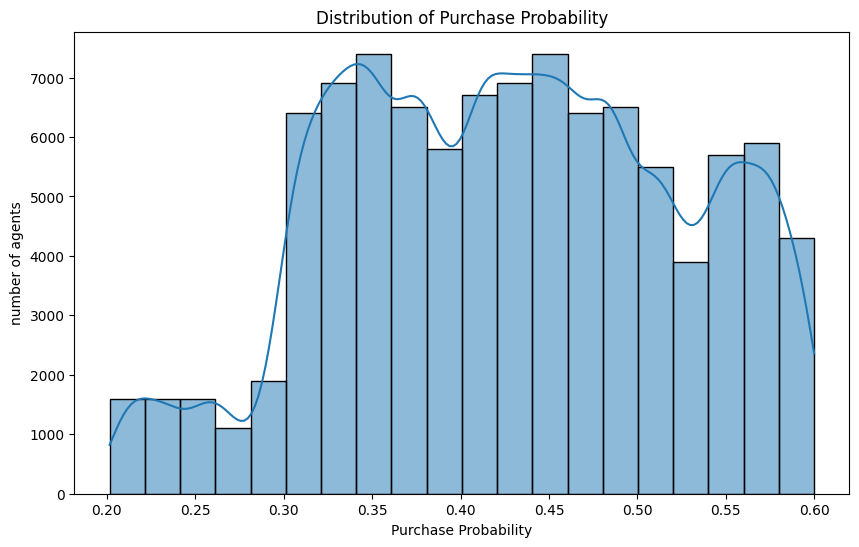

Total Purchases: 42561


In [21]:
results = baseline_model.datacollector.get_agent_vars_dataframe()
print(results.head())
    # Visualize purchases
plt.figure(figsize=(10, 6))
sns.histplot(results['Purchases'], bins=20, kde=True)
plt.title('Distribution of Purchase Probability')
plt.xlabel('Purchase Probability')
plt.ylabel('number of agents')
plt.show()

# Display total purchases made
print(f"Total Purchases: {baseline_model.total_purchases}")


Average Purchase Probability by Gender:
   Gender_Male  Gender_Female  Purchases
0        False           True   0.450037
1         True          False   0.350346


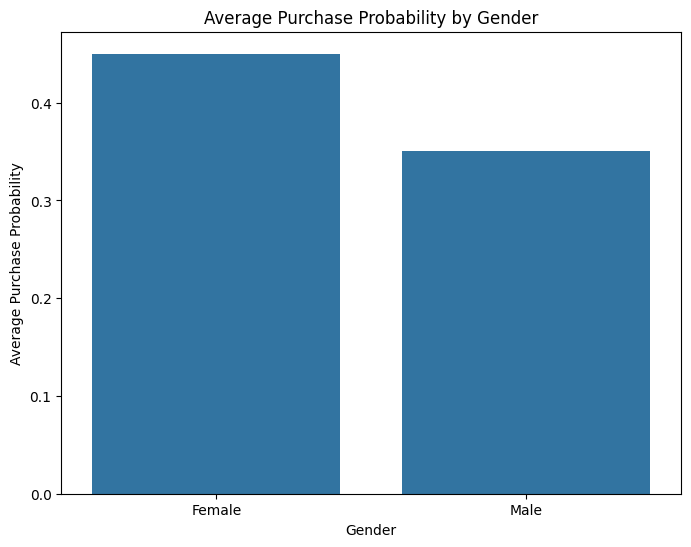


Average Purchase Probability by Language:
  Primary_Language  Purchases
0               de   0.425059
1               en   0.427709
2               es   0.440169
3               fr   0.423702
4               it   0.426210


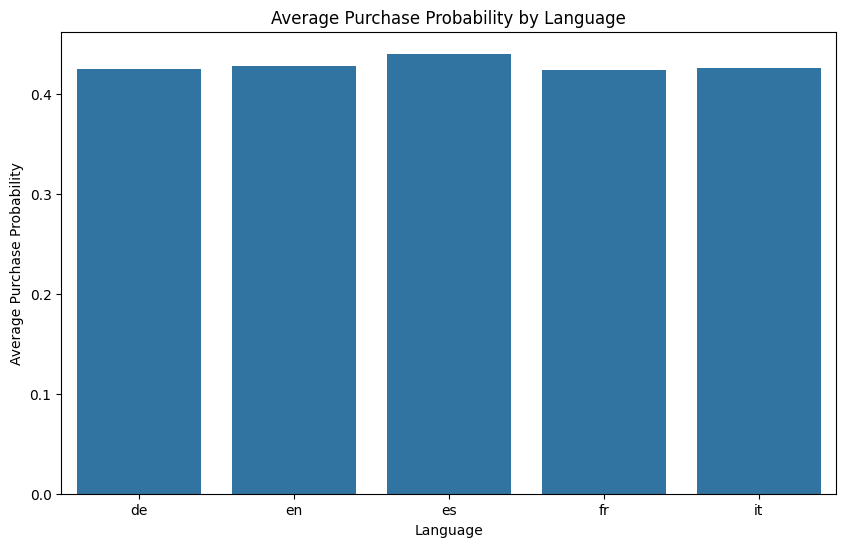

Total Purchases: 42561


In [23]:
gender_purchase_prob = results.groupby(['Gender_Male', 'Gender_Female'])['Purchases'].mean().reset_index()
print("\nAverage Purchase Probability by Gender:")
print(gender_purchase_prob)
plt.figure(figsize=(8, 6))
sns.barplot(x='Gender_Male', y='Purchases', data=gender_purchase_prob)
plt.title('Average Purchase Probability by Gender')
plt.xticks([0, 1], ['Female', 'Male'])  # Adjust labels based on your encoding
plt.xlabel('Gender')
plt.ylabel('Average Purchase Probability')
plt.show()

# Visualization of Average Purchase Probability by Language (Single Plot)
language_cols = [col for col in results.columns if col.startswith('Language_')]
results['Primary_Language'] = results[language_cols].idxmax(axis=1).str.replace('Language_', '')
language_purchase_prob = results.groupby('Primary_Language')['Purchases'].mean().reset_index()
print("\nAverage Purchase Probability by Language:")
print(language_purchase_prob)
plt.figure(figsize=(10, 6))
sns.barplot(x='Primary_Language', y='Purchases', data=language_purchase_prob)
plt.title('Average Purchase Probability by Language')
plt.xlabel('Language')
plt.ylabel('Average Purchase Probability')
plt.show()




# Display total purchases made
print(f"Total Purchases: {baseline_model.total_purchases}")

In [13]:
print("\n--- Running Unit Tests ---")
unittest.main(argv=['first-arg-is-ignored'], exit=False)

.

..
----------------------------------------------------------------------
Ran 3 tests in 0.030s

OK



--- Running Unit Tests ---
